# How Good is the Jointplot? A survey

The MEG/EEG analysis toolkit [MNE-Python](mne-tools.github.io) features a special kind of displaying
evoked effects - the JointPlot with spatial colors.

We surveyed a range of experts in EEG analysis to establish if this kind of plot is
any good. We showed various examples of Jointplots and traditional alternatives
(Image and Topo plots), and queried for subjective preferences as well as an objective
component detection task.

Here are the results of this survey. In summary, they indicate a subjective preference for jointplots
vs. other plots, at no loss in objectively inferred information content.

In [1]:
%matplotlib inline

import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

import mne

MEG/EEG signals are collected via multiple sensors placed over the scalp, which sample, with high
temporal resolution, brain activity. This means the observed signal has both a temporal structure
and a spatial structure. Due to [volume conduction](http://www.scholarpedia.org/article/Volume_conduction),
adjacent sensors pick up signals from the same brain area. But traditional methods for visualising
these results either fail to display all aspects of the signal, or do so very ineffectively.

To solve this problem, the *Jointplot with Spatial Colors* was introduced.

This is what jointplots look like.

Each line is one (EEG) sensor, colored by their location on the scalp (a *butterfly* plot with *spatial colors*);
above, topomaps are shown. This summarizes both the spatial and temporal structure of the effect.

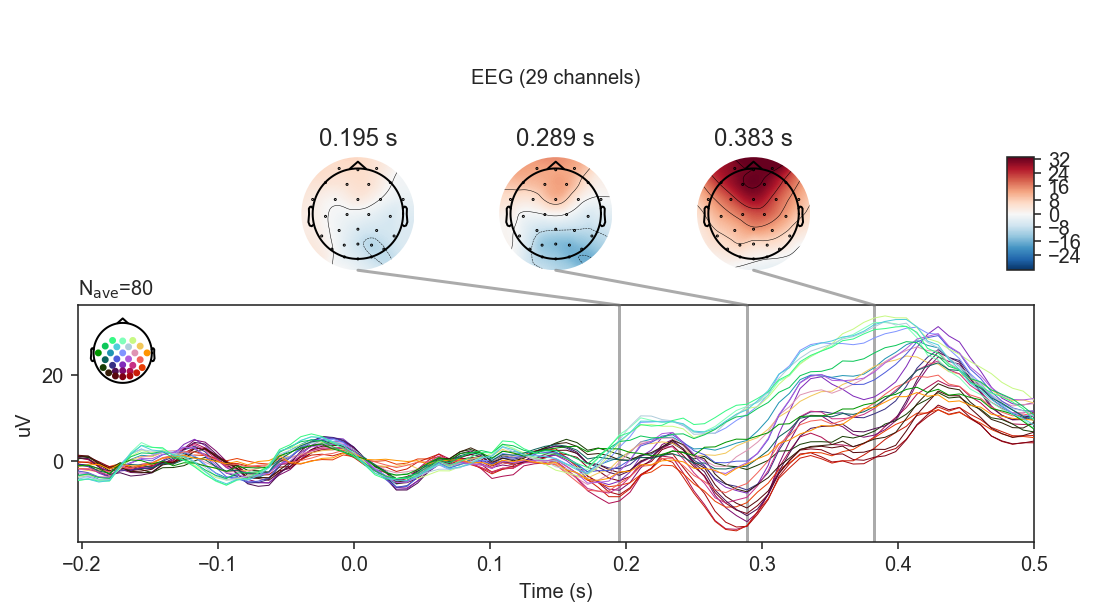

In [2]:
data_path = mne.datasets.testing.data_path()
fname = data_path + "/EEGLAB/test_raw.set"
montage = data_path + "/EEGLAB/test_chans.locs"

event_id = {"rt": 1, "square": 2}
eog = {"FPz", "EOG1", "EOG2"}
raw = mne.io.read_raw_eeglab(fname, eog=eog, montage=montage,
                             stim_channel=False)
events = mne.events_from_annotations(raw, event_id)[0]

epochs = mne.Epochs(raw, events=events, event_id={"square": 2})
evoked = epochs.average().pick_types(eeg=True)
evoked.plot_joint();

## Survey Results

First, we need to process the data - here, a CSV export from a Google survey.

In [3]:
df = pd.read_csv("data_project_722648_2018_09_06.csv", sep=";")
df = df.drop(['Comment', 'datetime', 'date_of_last_access', 'date_of_first_mail'], axis=1)

df = df.melt(id_vars=["VP", "Position", "Age", "UseFrequency", "Experience", "Sex"], value_name="Rating")

df["Component"] = ["P3" if c else "N170" for c in df.variable.str.startswith("P3")]
df["Plot Type"] = [[x for x in ("Topo", "Joint", "Image") if x in c][0] for c in df.variable]

df["Sham"] = df.variable.str.contains("Null")

df["Electrode_Coverage"] = "Dense"
df.loc[df.variable.str.contains("Few"), "Electrode_Coverage"] = "Sparse"

df["Task"] = df.variable.str.split("_", expand=True)[1]

df.loc[df["Sham"], "Component"] = "Sham"
df["Accuracy (%)"] = (df.Rating * 100).astype(int, errors="ignore")
df.loc[df["Task"] != "Component", "Accuracy (%)"] = np.nan  # not meaningful for the Component task

# exclude guessers
s = df.query("Task == 'Component'").groupby(["VP"])["Accuracy (%)"].mean()
include = set(s[s > 50].index)
df = df.query("VP in @include")

del df["variable"]

df.head()

,VP,Position,Age,UseFrequency,Experience,Sex,Rating,Component,Plot Type,Sham,Electrode_Coverage,Task,Accuracy (%)
0,11,4,54,1,4,2,0.0,Sham,Image,True,Sparse,Component,0.0
1,12,4,36,3,4,2,0.0,Sham,Image,True,Sparse,Component,0.0
3,14,3,36,1,4,2,0.0,Sham,Image,True,Sparse,Component,0.0
7,22,3,35,1,4,2,0.0,Sham,Image,True,Sparse,Component,0.0
8,33,2,30,1,4,2,1.0,Sham,Image,True,Sparse,Component,100.0


## Plot results

Was the accuracy in the component detection task better (or worse) for any of the plot types?

Did participants prefer any of the plots on virtue of **Ease of Interpretation**, **Aesthetics**,
or **Content**?

We use Seaborn to plot a few simple estimates, with 95% confidence intervals aggregated over participtans.

/Users/jona/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Component detection task')

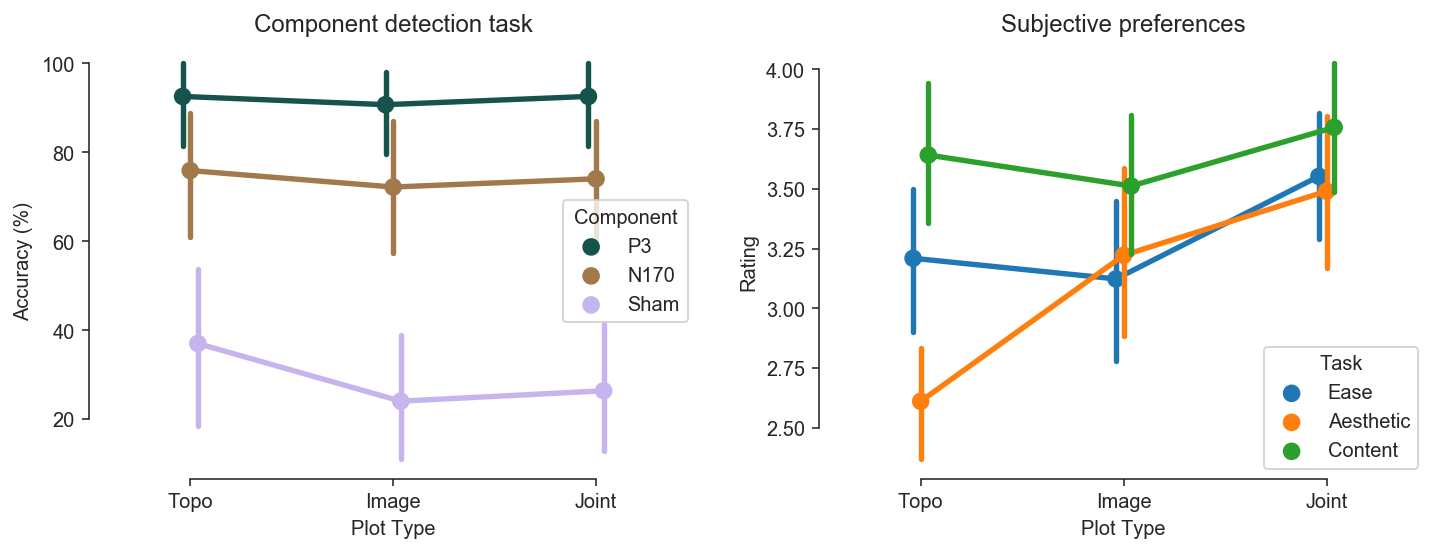

In [4]:
fig, (ax2, ax1) = plt.subplots(ncols=2, figsize=(12, 4))

sns.pointplot(x="Plot Type",
              hue="Task",
              y="Rating",
              data=df.query("Task != 'Component'"), 
              order=["Topo", "Image", "Joint"],
              dodge=True,
              units="VP",  # this takes care of the repeated-measures design when bootstrapping the CI
              ax=ax1
           )
sns.despine(trim=True, ax=ax1);
ax1.set_title("Subjective preferences")

sns.pointplot(x="Plot Type",
              hue="Component",
              y="Accuracy (%)", 
              order=["Topo", "Image", "Joint"],
              hue_order=["P3", "N170", "Sham"],
              data=df.query("Task == 'Component'"),
              dodge=True,
              units="VP",
              ax=ax2, palette="cubehelix")
sns.despine(trim=True, ax=ax2)
ax2.set_title("Component detection task")

Let's also directly check A/B preferences for Joint vs. the other two types of plots, as a percentage over participants:

In [5]:
for alternative in ("Image", "Topo"):
    # this is awkward because we can't query as Plot Type has a space
    df_ = df.loc[df["Plot Type"].str.contains(alternative) | df["Plot Type"].str.contains("Joint")]
    # this looks convoluted, but is essentially just checking for each user which plot type they on average prefer
    ratio = (df_.groupby("VP").apply(lambda x: x.groupby("Plot Type").mean()["Rating"].idxmax()) == "Joint").mean()
    print("Joint > " + alternative + ": {0:.1%}".format(ratio))

Joint > Image: 63.0%
Joint > Topo: 81.5%


## Statistical Evaluation

Finally, conduct some statistical inference: what is our confidence on the superiority
of the Jointplot in the true population?

We will use a multilevel (mixed-effects) model to account for response clustering within participants.

`statsmodels` `mixedlm` does not handle logistic regression well, so for the Accuracy,
we use a Generalized Estimating Equation.

In [6]:
keep = ["Rating", "Component", "Electrode_Coverage", "Plot Type", "VP"]

binomial=sm.families.Binomial()  # logistic regression
mdl = smf.gee("Rating ~ Component * Electrode_Coverage * C(Q('Plot Type'))",
                  data=df.query("Task == 'Component'")[keep].dropna(),
                  groups="VP", family=binomial)
res = mdl.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Rating   No. Observations:                  485
Model:                                 GEE   No. clusters:                       27
Method:                        Generalized   Min. cluster size:                  17
                      Estimating Equations   Max. cluster size:                  18
Family:                           Binomial   Mean cluster size:                18.0
Dependence structure:         Independence   Num. iterations:                     7
Date:                     Wed, 06 Mar 2019   Scale:                           1.000
Covariance type:                    robust   Time:                         13:51:44
=============================================================================================================================================
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     0.8650      0.421      2.052      0.040       0.039       1.691
Component[T.P3]                                                               1.2144      0.819      1.483      0.138      -0.391       2.820
Component[T.Sham]                                                            -2.3466      0.617     -3.801      0.000      -3.557      -1.137
Electrode_Coverage[T.Sparse]                                                  0.1848      0.554      0.334      0.739      -0.901       1.271
C(Q('Plot Type'))[T.Joint]                                                    0.1848      0.666      0.277      0.782      -1.121       1.491
C(Q('Plot Type'))[T.Topo]                                                    -0.4903      0.588     -0.835      0.404      -1.642       0.661
Component[T.P3]:Electrode_Coverage[T.Sparse]                                  0.2615      1.207      0.217      0.829      -2.104       2.627
Component[T.Sham]:Electrode_Coverage[T.Sparse]                                0.4318      0.946      0.456      0.648      -1.422       2.286
Component[T.P3]:C(Q('Plot Type'))[T.Joint]                                    0.9938      1.080      0.920      0.357      -1.122       3.110
Component[T.Sham]:C(Q('Plot Type'))[T.Joint]                                 -0.1383      0.933     -0.148      0.882      -1.967       1.691
Component[T.P3]:C(Q('Plot Type'))[T.Topo]                                     1.6690      1.399      1.193      0.233      -1.074       4.412
Component[T.Sham]:C(Q('Plot Type'))[T.Topo]                                   1.2788      0.860      1.487      0.137      -0.406       2.964
Electrode_Coverage[T.Sparse]:C(Q('Plot Type'))[T.Joint]                      -0.1848      0.900     -0.205      0.837      -1.949       1.579
Electrode_Coverage[T.Sparse]:C(Q('Plot Type'))[T.Topo]                        1.9662      0.864      2.277      0.023       0.274       3.659
Component[T.P3]:Electrode_Coverage[T.Sparse]:C(Q('Plot Type'))[T.Joint]      -1.4401      1.506     -0.956      0.339      -4.392       1.512
Component[T.Sham]:Electrode_Coverage[T.Sparse]:C(Q('Plot Type'))[T.Joint]     0.3102      1.329      0.233      0.816      -2.296       2.916
Component[T.P3]:Electrode_Coverage[T.Sparse]:C(Q('Plot Type'))[T.Topo]       -3.5912      1.845     -1.947      0.052      -7.207       0.025
Component[T.Sham]:Electrode_Coverage[T.Sparse]:C(Q('Plot Type'))[T.Topo]     -2.2644      1.015     -2.230      0.026      -4.254      -0.275
==============================================================================
Skew:                         -0.3349   Kurtosis:  

We can't really say participants were in general any better or worse with any of the plot types.
There are some marginally significant effects in the higher-order interactions (in particular topoplots),
but these are hard to interpret.

Now for the subjective ratings - Ease of Use, Aesthetics, Content.

In [7]:
for task in ("Ease", "Aesthetic", "Content"):
    mdl = smf.mixedlm("Rating ~ Component * Electrode_Coverage * C(Q('Plot Type'))",
                      data=df.query("Task == @task")[keep].dropna(),
                      groups="VP")
    res = mdl.fit()
    print("Task: " + task)
    print(res.summary())

Task: Ease
                                       Mixed Linear Model Regression Results
Model:                                 MixedLM                     Dependent Variable:                     Rating   
No. Observations:                      485                         Method:                                 REML     
No. Groups:                            27                          Scale:                                  0.9958   
Min. group size:                       17                          Likelihood:                             -711.2736
Max. group size:                       18                          Converged:                              Yes      
Mean group size:                       18.0                                                                         
--------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.   z

Finally, we can calculate an overall preference score of the Jointplot vs. the others.

In [8]:
df_ = (df.query("Task != 'Component'")
         .assign(IsJointplot=df["Plot Type"] == "Joint")
         .groupby(["IsJointplot", "VP"])
         .mean()
         .reset_index()[["Rating", "VP", "IsJointplot"]]
         .dropna())
mdl = smf.mixedlm("Rating ~ IsJointplot",
                  data=df_,
                  groups="VP")
res = mdl.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM   Dependent Variable:   Rating  
No. Observations:    54        Method:               REML    
No. Groups:          27        Scale:                0.1778  
Min. group size:     2         Likelihood:           -45.3455
Max. group size:     2         Converged:            Yes     
Mean group size:     2.0                                     
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           3.220    0.111 28.964 0.000  3.002  3.438
IsJointplot[T.True] 0.387    0.115  3.375 0.001  0.162  0.612
VP Var              0.156    0.228                           
=============================================================

"""

A strong preference for the Jointplot! $p < 0.001$, $z > 3$!